In [40]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import cv2
import pandas as pd
from matplotlib import pyplot as plt

from overcooked_ai.dataset_types import DetectionDataset, BBoxAnnotation, BBox

HOME_DIR = Path(os.environ.get("HOME", "/home/mimic"))
SOURCE_DIR: Path = HOME_DIR / "Overcooked2_1-1_jpeg/"
ds_gt_path = SOURCE_DIR / "detection_dataset.mar2025.json"
ds_gt = DetectionDataset.load_from_json(ds_gt_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


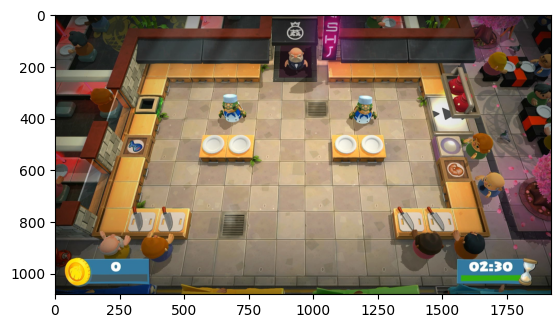

In [41]:
img_path = SOURCE_DIR / ds_gt.entries[0].file_name
frame_bgr = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

plt.imshow(frame_bgr)
plt.show()


In [42]:
from overcooked_ai.game_maps import world_1_1_tile_object_ids
from overcooked_ai.type_conversions import convert_from_world_tiles_to_xycats

world_1_1_grid_xycats = convert_from_world_tiles_to_xycats(world_1_1_tile_object_ids)
world_1_1_grid_xycats

array([[5.00e+01, 5.00e+01, 1.00e+00],
       [1.50e+02, 5.00e+01, 1.00e+00],
       [2.50e+02, 5.00e+01, 1.00e+00],
       [3.50e+02, 5.00e+01, 1.00e+00],
       [4.50e+02, 5.00e+01, 1.00e+00],
       [8.50e+02, 5.00e+01, 1.00e+00],
       [9.50e+02, 5.00e+01, 1.00e+00],
       [1.05e+03, 5.00e+01, 1.00e+00],
       [1.15e+03, 5.00e+01, 1.00e+00],
       [1.25e+03, 5.00e+01, 1.00e+00],
       [5.00e+01, 1.50e+02, 1.00e+00],
       [1.25e+03, 1.50e+02, 1.00e+00],
       [5.00e+01, 2.50e+02, 4.00e+00],
       [1.25e+03, 2.50e+02, 2.00e+00],
       [5.00e+01, 3.50e+02, 1.00e+00],
       [1.25e+03, 3.50e+02, 3.00e+00],
       [5.00e+01, 4.50e+02, 8.00e+00],
       [3.50e+02, 4.50e+02, 1.00e+00],
       [4.50e+02, 4.50e+02, 1.00e+00],
       [8.50e+02, 4.50e+02, 1.00e+00],
       [9.50e+02, 4.50e+02, 1.00e+00],
       [1.25e+03, 4.50e+02, 6.00e+00],
       [5.00e+01, 5.50e+02, 1.00e+00],
       [1.25e+03, 5.50e+02, 7.00e+00],
       [5.00e+01, 6.50e+02, 1.00e+00],
       [1.25e+03, 6.50e+0

In [43]:
import numpy as np

from overcooked_ai.ai_types import ObjectId, IsTile

def filter_tile_annotations(annotations: list[BBoxAnnotation]) -> list[BBoxAnnotation]:
    return [anno for anno in annotations if ObjectId(anno.category_id) in IsTile]

def convert_from_annotations_to_frame_coord_xycats(annotations: list[BBoxAnnotation]) -> np.ndarray:
    xycats = []
    for anno in annotations:
        x, y = anno.bbox.get_mid_xy()
        xycats.append((x, y, anno.category_id))
    return np.array(xycats).astype(np.float32)

frame_xycats = convert_from_annotations_to_frame_coord_xycats(filter_tile_annotations(ds_gt.entries[0].annotations))
frame_xycats

array([[3.9850000e+02, 2.1550000e+02, 1.0000000e+00],
       [4.8250000e+02, 2.1450000e+02, 1.0000000e+00],
       [5.7150000e+02, 2.1650000e+02, 1.0000000e+00],
       [6.6000000e+02, 2.1450000e+02, 1.0000000e+00],
       [7.5050000e+02, 2.1250000e+02, 1.0000000e+00],
       [1.0990000e+03, 2.1050000e+02, 1.0000000e+00],
       [1.1885000e+03, 2.1500000e+02, 1.0000000e+00],
       [1.2760000e+03, 2.1550000e+02, 1.0000000e+00],
       [1.3650000e+03, 2.1600000e+02, 1.0000000e+00],
       [1.4485000e+03, 2.1500000e+02, 1.0000000e+00],
       [3.8150000e+02, 2.7800000e+02, 1.0000000e+00],
       [1.4595000e+03, 2.7400000e+02, 1.0000000e+00],
       [3.6300000e+02, 3.5100000e+02, 4.0000000e+00],
       [1.4833646e+03, 3.4472589e+02, 2.0000000e+00],
       [3.3950000e+02, 4.2550000e+02, 1.0000000e+00],
       [1.5028273e+03, 4.2290445e+02, 3.0000000e+00],
       [3.1850000e+02, 5.0950000e+02, 8.0000000e+00],
       [1.5245000e+03, 5.1150000e+02, 6.0000000e+00],
       [2.8900000e+02, 6.000

In [44]:
from overcooked_ai.grid_homography import compute_frame_grid_homography

H_frame_grid, _ = compute_frame_grid_homography(frame_xycats, world_1_1_grid_xycats)
H_frame_grid

array([[ 9.69679674e-01, -3.54021983e-01,  4.13940773e+02],
       [-1.76302827e-03,  6.37382541e-01,  2.06047456e+02],
       [-9.59986515e-07, -3.70963183e-04,  1.13046111e+00]])

In [45]:
from overcooked_ai.grid_homography import apply_homography

world_1_1_grid_hxys = np.hstack((world_1_1_grid_xycats[:, :2], np.ones((world_1_1_grid_xycats.shape[0], 1))))
world_1_1_grid_hxys

tile_frame_hxys = apply_homography(H_frame_grid, world_1_1_grid_hxys)
tile_frame_xycats = np.hstack((tile_frame_hxys[:, :2], world_1_1_grid_xycats[:, 2:]))
tile_frame_xycats

array([[3.99979925e+02, 2.13900467e+02, 1.00000000e+00],
       [4.87233994e+02, 2.13760358e+02, 1.00000000e+00],
       [5.74503133e+02, 2.13620225e+02, 1.00000000e+00],
       [6.61787346e+02, 2.13480068e+02, 1.00000000e+00],
       [7.49086636e+02, 2.13339887e+02, 1.00000000e+00],
       [1.09843465e+03, 2.12778919e+02, 1.00000000e+00],
       [1.18580939e+03, 2.12638616e+02, 1.00000000e+00],
       [1.27319922e+03, 2.12498289e+02, 1.00000000e+00],
       [1.36060416e+03, 2.12357938e+02, 1.00000000e+00],
       [1.44802422e+03, 2.12217563e+02, 1.00000000e+00],
       [3.80846117e+02, 2.80587540e+02, 1.00000000e+00],
       [1.46508260e+03, 2.78918042e+02, 1.00000000e+00],
       [3.60344260e+02, 3.52042679e+02, 4.00000000e+00],
       [1.48336201e+03, 3.50392845e+02, 2.00000000e+00],
       [3.38322192e+02, 4.28796211e+02, 1.00000000e+00],
       [1.50299839e+03, 4.27173609e+02, 3.00000000e+00],
       [3.14604317e+02, 5.11460139e+02, 8.00000000e+00],
       [6.16719164e+02, 5.11063

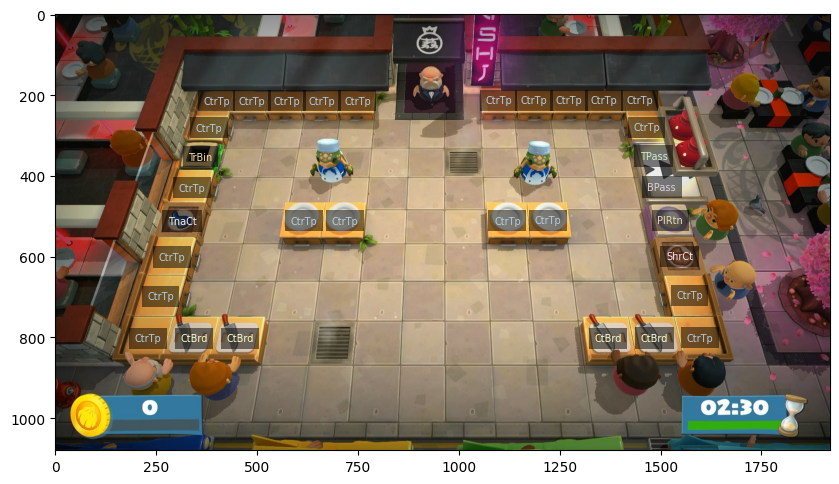

In [46]:
from overcooked_ai.ai_types import map_from_object_id_to_short_label
from matplotlib import pyplot as plt
pastel1 = plt.cm.Pastel1

plt.figure(figsize=(10, 10))
plt.imshow(frame_bgr)
for x, y, category_id in tile_frame_xycats:
    category_id = int(category_id)
    object_id = ObjectId(category_id)
    object_label = map_from_object_id_to_short_label[object_id]
    plt.text(x, y, object_label, color=pastel1(category_id % len(pastel1.colors)), fontsize=7, ha="center", va="center", bbox=dict(facecolor="black", alpha=0.5, edgecolor="none"))
plt.show()

In [47]:
# Load model

import os
from pathlib import Path

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from overcooked_ai.detectron2_addons import StandardROIHeadsWithClassProbs  # noqa

HOME_DIR = Path(os.environ.get("HOME", "/home/mimic"))
SOURCE_DIR = HOME_DIR /  "Overcooked2_1-1_jpeg/"
MODELS_DIR = HOME_DIR / "objdet/overcooked_models/"
CKPT_DIR = MODELS_DIR / "20250323_225544"

cfg_path = str(CKPT_DIR / "model.yaml")
cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.MODEL.WEIGHTS = str(CKPT_DIR / "model_final.pth")

# Use tuned NMS_THRESH (reject overlapping bboxes with IOU > NMS_THRESH) and SCORE_THRESH (reject low-confidence bboxes)
# - first hand-tune NMS_THRESH manually while keeping SCORE_THRESH very close to 0, and ensure number of detections don't come close to model max of 500
# - compute pairwise IOU thresholds, for detections among single class. Sort them, these are the IOU threshold breakpoints (or an upper bound, since after culling some bboxes, certain IOUs may drop)
# -
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.035

# Use custom ROI head, to be able to obtain pred_class_probs
cfg.MODEL.ROI_HEADS.NAME = "StandardROIHeadsWithClassProbs"

print(f"Loading model: {cfg.MODEL.WEIGHTS}")
model_pred = DefaultPredictor(cfg)

Loading model: /home/mimic/objdet/overcooked_models/20250323_225544/model_final.pth


In [48]:
# Run all frames through model, and save results as Dataset

import tqdm

ds = DetectionDataset.load_from_json(ds_gt_path)

map_from_entry_idx_to_H_frame_grids = {}
map_from_entry_idx_to_matched_frame_grid_idxs = {}
for frame_idx, entry in enumerate(tqdm.tqdm(ds.entries, desc="entry")):
    # Load image
    img_path = SOURCE_DIR / entry.file_name
    img_bgr = cv2.imread(str(img_path))

    # Run object detection
    # NOTE: DefaultPredictor expects RGB images
    out = model_pred(img_bgr)["instances"].to("cpu")
    pred_boxes = out.pred_boxes.tensor.numpy().astype(float)
    category_ids = out.pred_classes.numpy().astype(int)
    scores = out.scores.numpy().astype(float)
    pred_class_probs = out.pred_class_probs.numpy().astype(float)
    entry.annotations = [
        BBoxAnnotation(bbox=BBox(*pred_bbox), category_id=int(category_id), score=float(score), class_probs=[float(p) for p in probs])
        for pred_bbox, category_id, score, probs in zip(pred_boxes, category_ids, scores, pred_class_probs)
    ]

    # Solve homography
    frame_xycats = convert_from_annotations_to_frame_coord_xycats(filter_tile_annotations(entry.annotations))
    H_frame_grid, matched_frame_grid_idxs = compute_frame_grid_homography(frame_xycats, world_1_1_grid_xycats)

    # TODO: refactor this as hvec
    H_grid_frame = np.linalg.inv(H_frame_grid)
    entry.H_grid_img = [float(x) for x in H_grid_frame.flatten()]

    map_from_entry_idx_to_H_frame_grids[frame_idx] = H_frame_grid
    map_from_entry_idx_to_matched_frame_grid_idxs[frame_idx] = matched_frame_grid_idxs

ds.save_to_json(SOURCE_DIR / "detection_dataset_pred.json")

entry: 100%|██████████| 860/860 [00:51<00:00, 16.72it/s]


In [49]:
from overcooked_ai.dataset_stats import compute_num_tp_fp_fn

stats = []
for frame_idx in range(len(ds.entries)):
    entry = ds.entries[frame_idx]
    annotations = entry.annotations

    gt_annotations = ds_gt.entries[frame_idx].annotations
    tp, fp, fn = compute_num_tp_fp_fn(annotations, gt_annotations)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    stats.append({
        "frame_idx": frame_idx,
        "precision": precision,
        "recall": recall,
        "tp": tp,
        "fp": fp,
        "fn": fn,
    })

df_stats = pd.DataFrame(stats)
df_stats

frame_idx  precision  recall  tp  fp  fn
0            0   1.000000     1.0  39   0   0
1            1   1.000000     1.0  39   0   0
2            2   1.000000     1.0  39   0   0
3            3   0.975000     1.0  39   1   0
4            4   1.000000     1.0  39   0   0
..         ...        ...     ...  ..  ..  ..
855        855   1.000000     1.0  46   0   0
856        856   0.958333     1.0  46   2   0
857        857   0.979167     1.0  47   1   0
858        858   0.979167     1.0  47   1   0
859        859   0.979167     1.0  47   1   0

[860 rows x 6 columns]

In [50]:
import plotly.express as px

px.scatter(df_stats, x="frame_idx", y="fp")
# px.scatter(df_stats, x="frame_idx", y="fn")

Precision: 1.0, Recall: 1.0


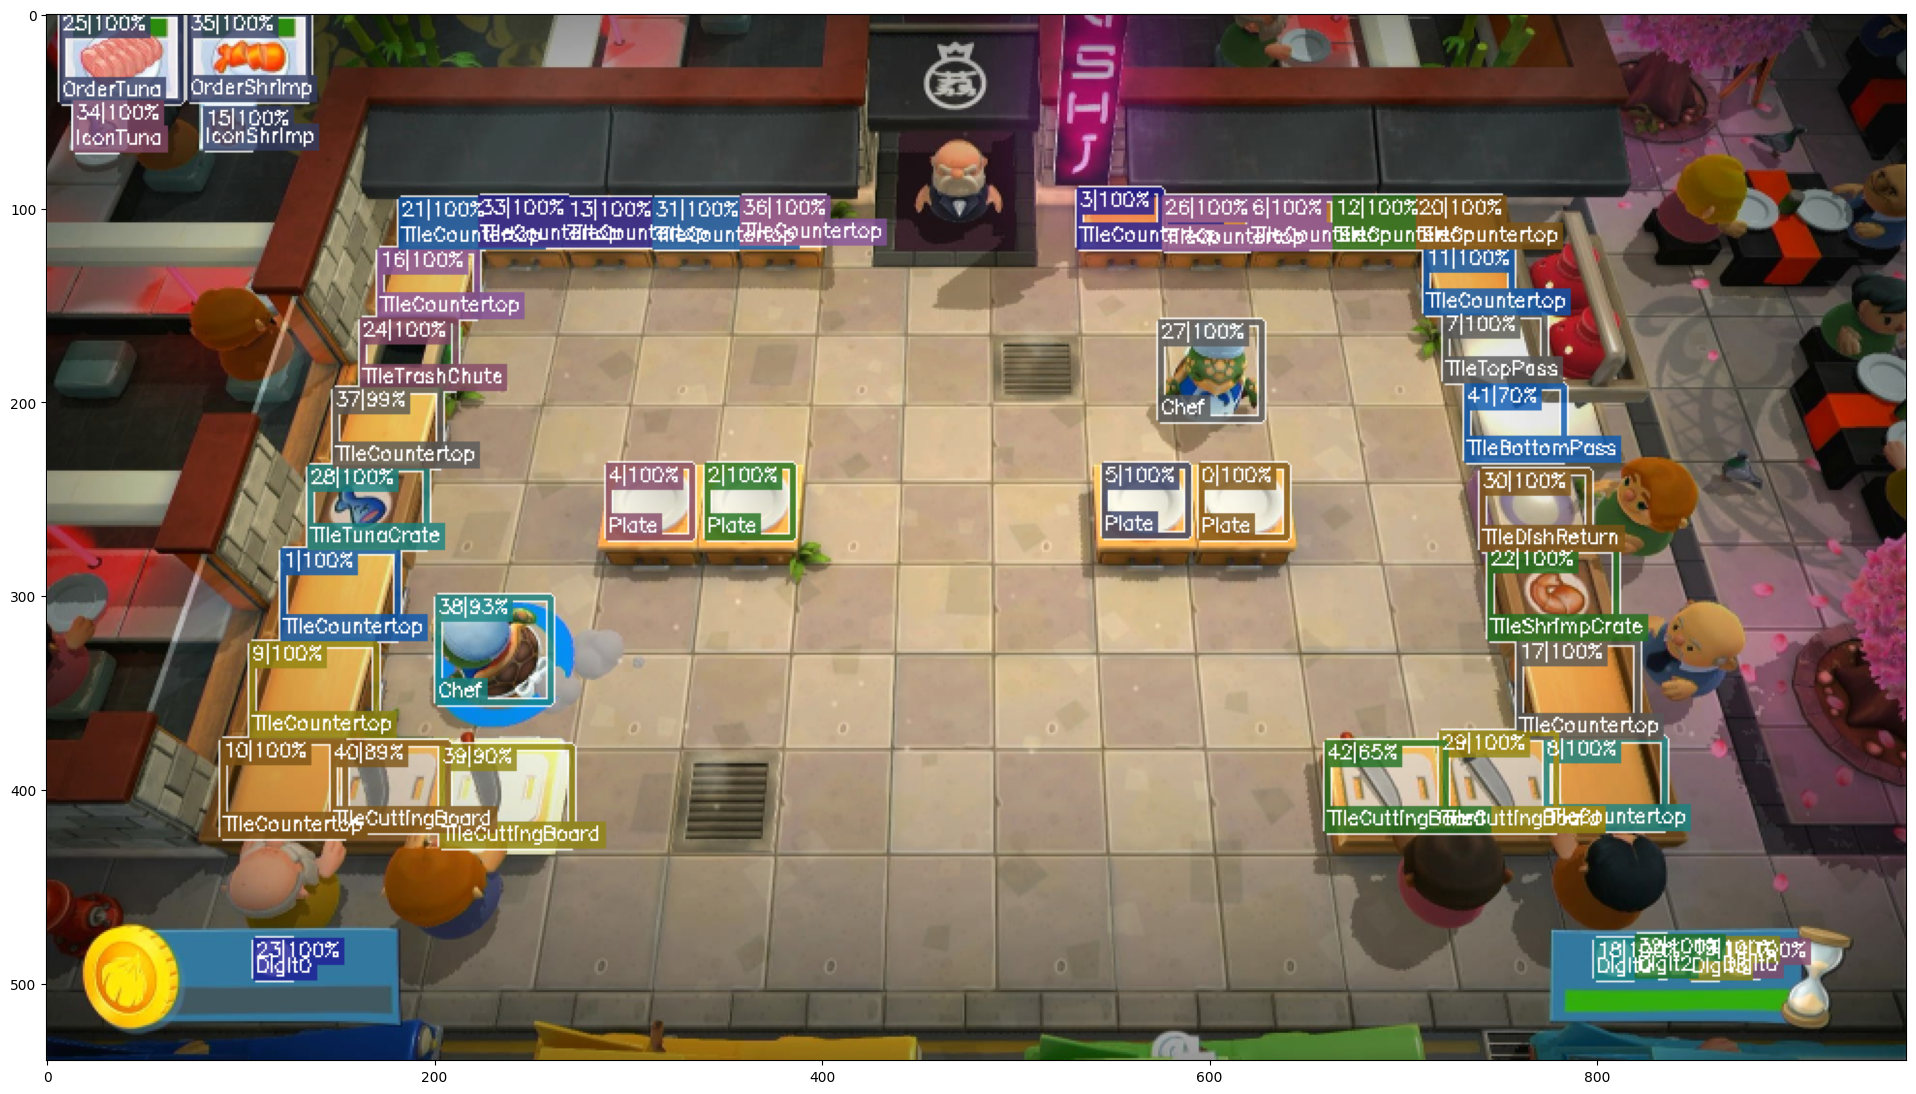

In [57]:
from overcooked_ai.visualizations import plot_track_annotations

frame_idx = 10

entry = ds.entries[frame_idx]
annotations = entry.annotations

gt_annotations = ds_gt.entries[frame_idx].annotations
tp, fp, fn = compute_num_tp_fp_fn(annotations, gt_annotations)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f"Precision: {precision}, Recall: {recall}")

idxs = range(len(annotations))
img_bgr = cv2.imread(os.path.join(SOURCE_DIR, entry.file_name))
plot_labels = ds.thing_classes
img_annos = plot_track_annotations(img_bgr, annotations, idxs, plot_labels, img_scale=0.5)
plt.figure(figsize=(24, 20))
plt.imshow(cv2.cvtColor(img_annos, cv2.COLOR_BGR2RGB))

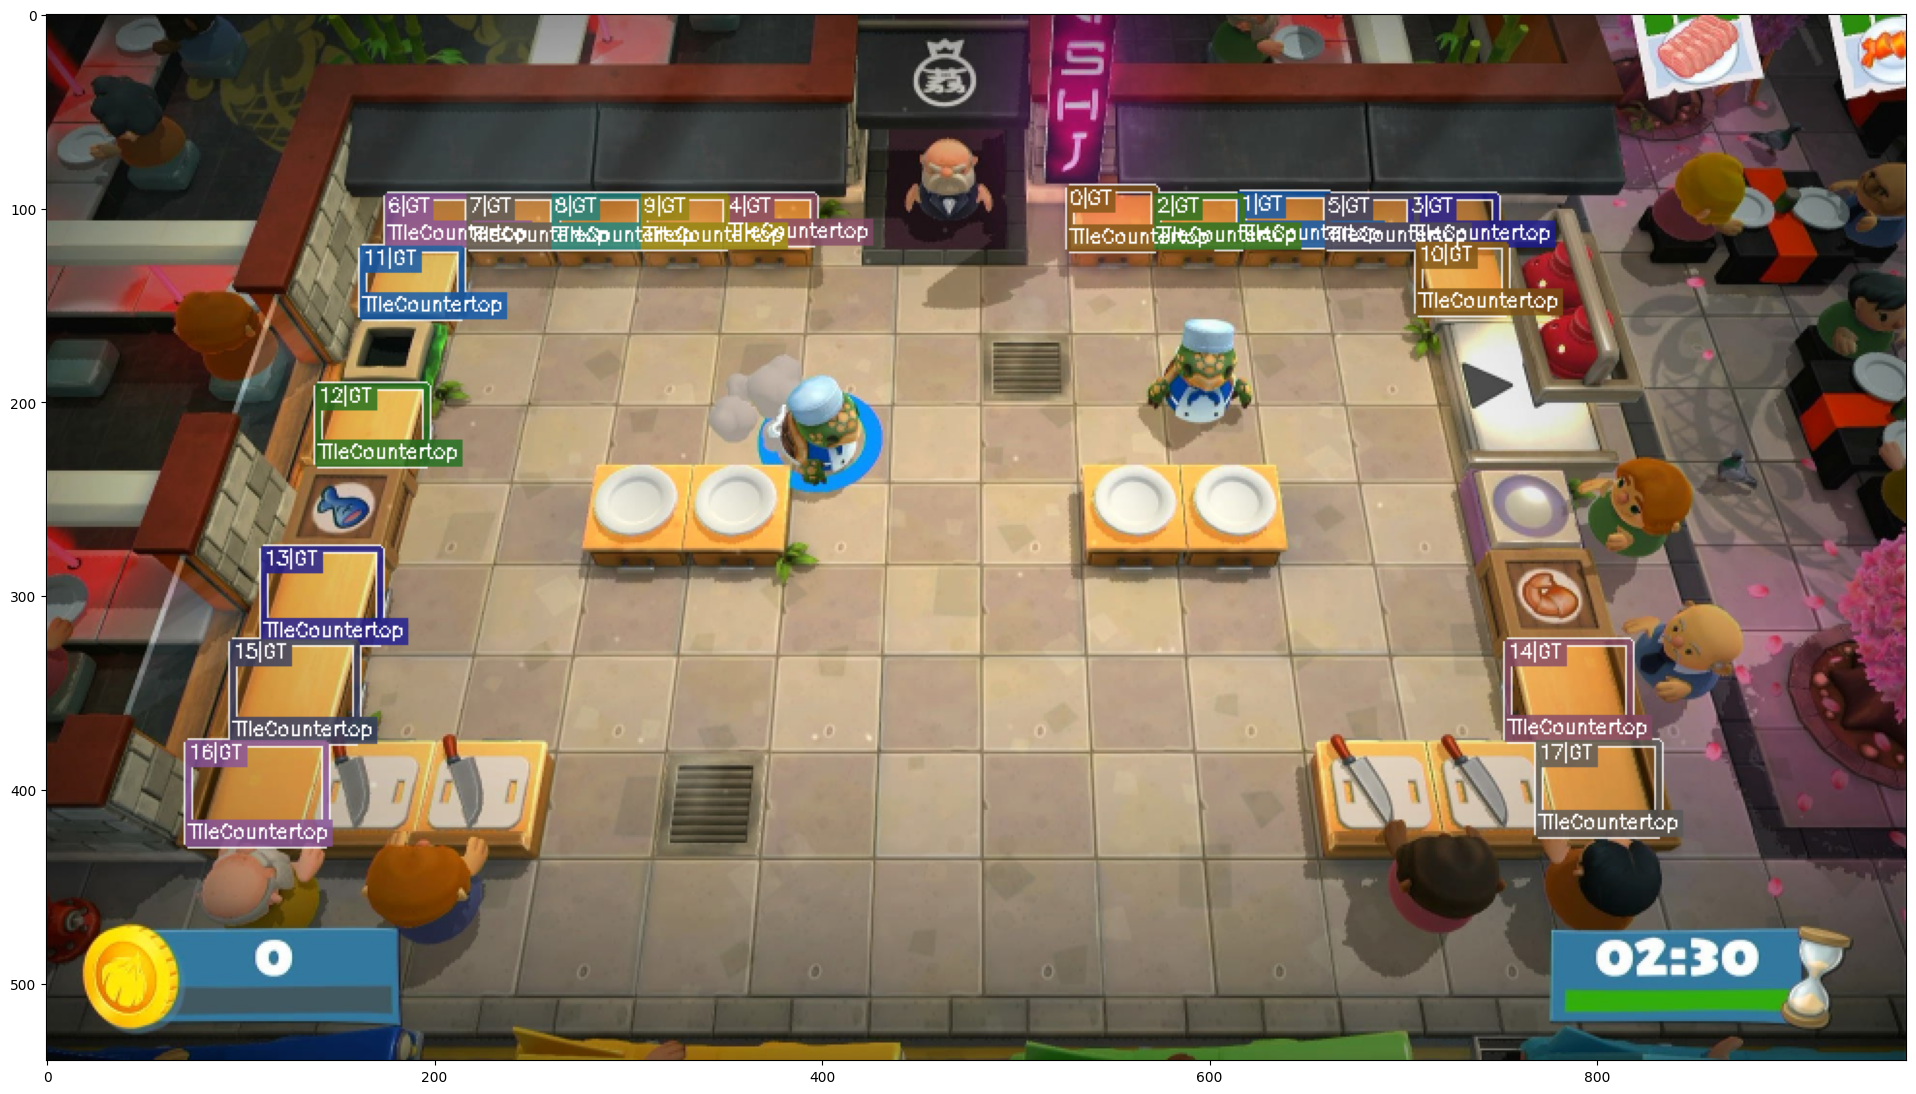

In [60]:
from overcooked_ai.visualizations import plot_track_annotations
from overcooked_ai.ai_types import map_from_object_id_to_short_label

plot_labels = ds_gt.thing_classes

entry = ds_gt.entries[2]

img_bgr = cv2.imread(os.path.join(SOURCE_DIR, entry.file_name))
annotations = entry.annotations
annotations = [anno for anno in annotations if anno.category_id == 1]
annotations = sorted(annotations, key=lambda anno: (anno.bbox.y_min_px, anno.bbox.x_min_px, anno.bbox.y_max_px, anno.bbox.x_max_px))
idxs = range(len(annotations))
img_annos = plot_track_annotations(img_bgr, annotations, idxs, plot_labels, img_scale=0.5)

plt.figure(figsize=(24, 20))
plt.imshow(cv2.cvtColor(img_annos, cv2.COLOR_BGR2RGB))